# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### План работы
- Открыть файлы с данными
- Провести предобработку и исследовательский анализ данных
- Проверить данные и откорректировать их, если потребуется.
- Провести исследовательский анализ представленных данных. Описать найденные особенности.
- Вычислить бизнес-метрику
- Оценить прибыль отеля без внедрения депозитов.
- Разработать модель ML
- Обучить разные модели и оцените их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке. 
- Выберать метрику для обучения.
- Оценить прибыль, которую принесёт выбранная модель за год.
- Выявить признаки «ненадёжного» клиента
- На основе исследовательского анализа данных описать клиента, склонного к отказу от брони.
- Написать общий вывод: описать модель, которая решает задачу с наибольшей выгодой для бизнеса; дать бизнесу рекомендации по результатам проделанной работы.

### Цель работы
- Разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит.

## Загрузка файлов с данными

In [194]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

In [195]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

In [196]:
df_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [197]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 65229 entries, 0 to 65228

Data columns (total 25 columns):

 #   Column                          Non-Null Count  Dtype  

---  ------                          --------------  -----  

 0   id                              65229 non-null  int64  

 1   is_canceled                     65229 non-null  int64  

 2   lead_time                       65229 non-null  float64

 3   arrival_date_year               65229 non-null  int64  

 4   arrival_date_month              65229 non-null  object 

 5   arrival_date_week_number        65229 non-null  int64  

 6   arrival_date_day_of_month       65229 non-null  int64  

 7   stays_in_weekend_nights         65229 non-null  int64  

 8   stays_in_week_nights            65229 non-null  int64  

 9   adults                          65229 non-null  float64

 10  children                        65229 non-null  float64

 11  babies                          65229 non-null  float64

 12  meal           

In [198]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 32412 entries, 0 to 32411

Data columns (total 25 columns):

 #   Column                          Non-Null Count  Dtype  

---  ------                          --------------  -----  

 0   id                              32412 non-null  int64  

 1   is_canceled                     32412 non-null  int64  

 2   lead_time                       32412 non-null  float64

 3   arrival_date_year               32412 non-null  int64  

 4   arrival_date_month              32412 non-null  object 

 5   arrival_date_week_number        32412 non-null  int64  

 6   arrival_date_day_of_month       32412 non-null  int64  

 7   stays_in_weekend_nights         32412 non-null  int64  

 8   stays_in_week_nights            32412 non-null  int64  

 9   adults                          32412 non-null  float64

 10  children                        32412 non-null  float64

 11  babies                          32412 non-null  float64

 12  meal           

Данные загружены и проверены на наличие пропусков и соответствие документации, можно переходить к их изучению. 

## Предобработка и исследовательский анализ данных

In [199]:
# Проверим данные на наличие дублей
train_duplicates = df_train.duplicated()
test_duplicates = df_test.duplicated()

In [200]:
print(train_duplicates.value_counts())

False    65229

dtype: int64


In [201]:
print(test_duplicates.value_counts())

False    32412

dtype: int64


Явные дубликаты отсутствуют в обоих датасетах. Не явные могут быть в столбца country и distribution_channel. Проверим их

In [202]:
df_train['country'].unique().tolist()

['GBR',
 'PRT',
 'ESP',
 'IRL',
 'FRA',
 'ROU',
 'NOR',
 'USA',
 'DEU',
 'BEL',
 'CHE',
 'CN',
 'GRC',
 'NLD',
 'ARG',
 'RUS',
 'SWE',
 'POL',
 'EST',
 'CZE',
 'ITA',
 'FIN',
 'DNK',
 'MOZ',
 'BWA',
 'LUX',
 'BRA',
 'SVN',
 'ALB',
 'CHN',
 'MEX',
 'MAR',
 'SMR',
 'LVA',
 'CHL',
 'AUT',
 'LTU',
 'TUR',
 'ISR',
 'IND',
 'CYM',
 'AUS',
 'CPV',
 'ZWE',
 'DZA',
 'KOR',
 'CRI',
 'HUN',
 'TUN',
 'ARE',
 'HRV',
 'HKG',
 'IRN',
 'GIB',
 'JEY',
 'URY',
 'ZAF',
 'COL',
 'GGY',
 'KWT',
 'CYP',
 'KAZ',
 'THA',
 'DOM',
 'NGA',
 'BLR',
 'VEN',
 'UKR',
 'ARM',
 'JPN',
 'LKA',
 'MYS',
 'BIH',
 'MUS',
 'OMN',
 'SUR',
 'JAM',
 'BGR',
 'CIV',
 'SRB',
 'JOR',
 'SYR',
 'PHL',
 'PRI',
 'SGP',
 'BDI',
 'LBN',
 'AGO',
 'VNM',
 'AZE',
 'PLW',
 'NZL',
 'EGY',
 'MDV',
 'CMR',
 'MLT',
 'SVK',
 'MWI',
 'STP',
 'TWN',
 'IDN',
 'SEN',
 'PER',
 'SAU',
 'KNA',
 'ETH',
 'ECU',
 'IRQ',
 'AND',
 'HND',
 'PAK',
 'GEO',
 'ZMB',
 'QAT',
 'KHM',
 'MCO',
 'BGD',
 'ISL',
 'UZB',
 'IMN',
 'TJK',
 'NIC',
 'BEN',
 'MAC',
 'VGB',
 

Здесь нет повторяющихся значений

In [203]:
df_test['country'].unique().tolist()

['PRT',
 'AUT',
 'BEL',
 'DEU',
 'BRA',
 'GBR',
 'ESP',
 'FRA',
 'ITA',
 'LUX',
 'CHE',
 'EST',
 'NGA',
 'IRL',
 'CN',
 'POL',
 'AUS',
 'NLD',
 'KOR',
 'ROU',
 'USA',
 'CHL',
 'DNK',
 'FIN',
 'RUS',
 'SWE',
 'HUN',
 'HRV',
 'MDV',
 'ZAF',
 'ISR',
 'NOR',
 'CHN',
 'ARE',
 'MAR',
 'COL',
 'FJI',
 'LVA',
 'LBN',
 'PHL',
 'HKG',
 'SYC',
 'GIB',
 'AGO',
 'MYS',
 'MDG',
 'IDN',
 'LTU',
 'ISL',
 'TUR',
 'ARG',
 'JPN',
 'SVN',
 'SVK',
 'BGR',
 'CAF',
 'JAM',
 'UZB',
 'UKR',
 'IND',
 'CZE',
 'URY',
 'NZL',
 'NPL',
 'SRB',
 'CPV',
 'IRN',
 'KAZ',
 'BHS',
 'SUR',
 'CUB',
 'PAK',
 'MAC',
 'CYP',
 'JOR',
 'GRC',
 'KWT',
 'TWN',
 'VNM',
 'SGP',
 'DOM',
 'VEN',
 'SEN',
 'BLR',
 'TZA',
 'LIE',
 'GNB',
 'SAU',
 'DZA',
 'PER',
 'AZE',
 'EGY',
 'ETH',
 'KEN',
 'THA',
 'MLT',
 'ECU',
 'AND',
 'IMN',
 'BHR',
 'TUN',
 'MNE',
 'MEX',
 'BEN',
 'MOZ',
 'UMI',
 'JEY',
 'MYT',
 'QAT',
 'BGD',
 'GAB',
 'CIV',
 'ZWE',
 'GTM',
 'ALB',
 'GHA',
 'ATA',
 'ASM',
 'PAN',
 'CRI',
 'MCO',
 'MUS',
 'SYR',
 'TGO',
 'IRQ',
 

Аналогично

In [204]:
df_train['distribution_channel'].unique().tolist()

['Direct', 'TA/TO', 'Corporate', 'GDS']

In [205]:
df_test['distribution_channel'].unique().tolist()

['TA/TO', 'Direct', 'Corporate', 'GDS']

Здесь дублей тоже нет.

Проверим столбцы с типом данных object на наличие ошибок и несоответствий

In [206]:
df_train['arrival_date_month'].unique().tolist()

['July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June']

In [207]:
df_train['meal'].unique().tolist()

['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC']

в столбце meal найдены лишние пробелы. От них нужно будет избавиться. 

In [208]:
df_train['meal'] = df_train['meal'].str.strip()

In [209]:
df_train['meal'].unique().tolist()

['BB', 'FB', 'HB', 'SC']

In [210]:
df_test['meal'] = df_test['meal'].str.strip()

In [211]:
df_test['meal'].unique().tolist()

['BB', 'HB', 'SC', 'FB']

In [212]:
df_train['country'].unique().tolist()

['GBR',
 'PRT',
 'ESP',
 'IRL',
 'FRA',
 'ROU',
 'NOR',
 'USA',
 'DEU',
 'BEL',
 'CHE',
 'CN',
 'GRC',
 'NLD',
 'ARG',
 'RUS',
 'SWE',
 'POL',
 'EST',
 'CZE',
 'ITA',
 'FIN',
 'DNK',
 'MOZ',
 'BWA',
 'LUX',
 'BRA',
 'SVN',
 'ALB',
 'CHN',
 'MEX',
 'MAR',
 'SMR',
 'LVA',
 'CHL',
 'AUT',
 'LTU',
 'TUR',
 'ISR',
 'IND',
 'CYM',
 'AUS',
 'CPV',
 'ZWE',
 'DZA',
 'KOR',
 'CRI',
 'HUN',
 'TUN',
 'ARE',
 'HRV',
 'HKG',
 'IRN',
 'GIB',
 'JEY',
 'URY',
 'ZAF',
 'COL',
 'GGY',
 'KWT',
 'CYP',
 'KAZ',
 'THA',
 'DOM',
 'NGA',
 'BLR',
 'VEN',
 'UKR',
 'ARM',
 'JPN',
 'LKA',
 'MYS',
 'BIH',
 'MUS',
 'OMN',
 'SUR',
 'JAM',
 'BGR',
 'CIV',
 'SRB',
 'JOR',
 'SYR',
 'PHL',
 'PRI',
 'SGP',
 'BDI',
 'LBN',
 'AGO',
 'VNM',
 'AZE',
 'PLW',
 'NZL',
 'EGY',
 'MDV',
 'CMR',
 'MLT',
 'SVK',
 'MWI',
 'STP',
 'TWN',
 'IDN',
 'SEN',
 'PER',
 'SAU',
 'KNA',
 'ETH',
 'ECU',
 'IRQ',
 'AND',
 'HND',
 'PAK',
 'GEO',
 'ZMB',
 'QAT',
 'KHM',
 'MCO',
 'BGD',
 'ISL',
 'UZB',
 'IMN',
 'TJK',
 'NIC',
 'BEN',
 'MAC',
 'VGB',
 

In [213]:
df_train['distribution_channel'].unique().tolist()

['Direct', 'TA/TO', 'Corporate', 'GDS']

In [214]:
df_train['reserved_room_type'].unique().tolist()

['A               ',
 'C               ',
 'D               ',
 'E               ',
 'G               ',
 'F               ',
 'B               ']

аналогично со столбцом meal. нужно будет убрать лишние пропуски

In [215]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()

In [216]:
df_train['reserved_room_type'].unique().tolist()

['A', 'C', 'D', 'E', 'G', 'F', 'B']

In [217]:
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()

In [218]:
df_test['reserved_room_type'].unique().tolist()

['A', 'E', 'G', 'D', 'F', 'C', 'B']

In [219]:
df_train['customer_type'].unique().tolist()

['Transient', 'Contract', 'Transient-Party', 'Group']

В обоих датасетах пропуски не найдены. По ходу проверки были найдены лишние и удалены пробелы в некоторых столбац.

Проверим типы данных в столбцах и заменим их там, где это необходимо. Например, если в столбце только два варианта, отвечающие на вопрос да или нет, вместо цифр можно использовать Булев массив

In [220]:
#Добавим два столбца -- price и cleaning_cost -- цену за номер и стоимость разового обслуживания
def price(row):
    room_type = row['reserved_room_type']
    if room_type == 'A':
        return 1000
    if room_type == 'B':
        return 800
    if room_type == 'C':
        return 600
    if room_type == 'D':
        return 550
    if room_type == 'E':
        return 500
    if room_type == 'F':
        return 450
    if room_type == 'G':
        return 350
# Применим функцию к датасетам    
df_train['price'] = df_train.apply(price, axis=1)
df_test['price'] = df_test.apply(price,axis=1)

In [221]:
def cl_cost(row):
    room_type = row['reserved_room_type']
    if room_type == 'A':
        return 400
    if room_type == 'B':
        return 350
    if room_type == 'C':
        return 350
    if room_type == 'D':
        return 150
    if room_type == 'E':
        return 150
    if room_type == 'F':
        return 150
    if room_type == 'G':
        return 150
# Применим функцию к датасетам
df_train['cleaning_cost'] = df_train.apply(cl_cost, axis=1)
df_test['cleaning_cost'] = df_test.apply(cl_cost, axis=1)

In [222]:
# Также добавим столлбец coeff со значениями сезонного коэффициента
def coeff(row):    
    coeff_value = row['arrival_date_month']    
    coeff_40 = ['June', 'July', 'August']
    coeff_20 = ['March', 'April', 'May', 'September', 'October', 'November']    
    
    if coeff_value in coeff_40:
        return 0.4    
    if coeff_value in coeff_20:
        return 0.2    
    else:
        return 1

In [223]:
# Применим функцию к датасетам
df_train['coeff'] = df_train.apply(coeff, axis=1)
df_test['coeff'] = df_test.apply(coeff, axis=1)

In [224]:
# добавим столбец new_price, чтобы посчитать стоимость номера с учетом сезонного коэффициента
def new_price(row):
    price = row['price']
    coeff = row['coeff']
    if coeff <= 0.4:
        new_price = price + (price * coeff)
    else:
        new_price = price
    return new_price

In [225]:
# Применим функцию к датасетам
df_train['new_price'] = df_train.apply(new_price, axis=1)
df_test['new_price'] = df_test.apply(new_price, axis=1)

In [226]:
# Теперь от столбцов price и coeff можно избавиться, т.к. мы посчитали полную стоимость с учетом коэффициентов
df_train = df_train.drop('price', axis=1)
df_test = df_test.drop('price', axis=1)
df_train.head(3)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,coeff,new_price
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,A,0,0,Transient,0,0,1,400,0.4,1400.0
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,A,0,0,Transient,0,1,2,400,0.4,1400.0
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,C,0,0,Transient,0,0,2,350,0.4,840.0


In [227]:
df_train = df_train.drop('coeff', axis=1)
df_test = df_test.drop('coeff', axis=1)
df_train.head(3)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,new_price
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,A,0,0,Transient,0,0,1,400,1400.0
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,A,0,0,Transient,0,1,2,400,1400.0
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,C,0,0,Transient,0,0,2,350,840.0


In [228]:
#Удалим столбец 'id' в обоих датасетах, т.к. он не повлияет на качество обучения модели
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [229]:
#Перед тем как применять энкодинг нужно избавиться от разности данных в обучающем и тестовом датасете.
df_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [230]:
df_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [231]:
values_to_drop = ['September','October', 'November', 'December']
df_train = df_train[~df_train['arrival_date_month'].isin(values_to_drop)]
df_train['arrival_date_month'].unique()

array(['July', 'August', 'January', 'February', 'March', 'April', 'May',
       'June'], dtype=object)

In [232]:
df_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

В датасете df_test не хватало данных за 4 месяца. Т.к. взять их было неоткуда, пришлось от них избавиться.

In [233]:
# Проверим совпадают ли значения в столбце meal
print(df_test['meal'].unique())
print(df_train['meal'].unique())

['BB' 'HB' 'SC' 'FB']

['BB' 'FB' 'HB' 'SC']


In [234]:
# Посмотрим на столбец country
print(df_test['country'].unique())
print()
print(df_train['country'].unique())

['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'

 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'

 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'

 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'

 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'

 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'

 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'

 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'

 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'

 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'

 'MCO' 'MUS' 'SYR' 'TGO' 'IRQ' 'LKA' 'BIH' 'PRY' 'MRT' 'ABW' 'NCL' 'STP'

 'KIR' 'SDN' 'PRI' 'ATF' 'CMR' 'TJK' 'LBY' 'SLE' 'SLV' 'LAO' 'FRO']



['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'

 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 

In [235]:
#Думаю, что страны не повлияют на качество модели, удалю эти столбцы перед энкодингом 
df_test = df_test.drop(['country'], axis=1)
df_train = df_train.drop(['country'], axis=1)

In [236]:
#то же самое с колонкой distribution_channel
df_test = df_test.drop(['distribution_channel'], axis=1)
df_train = df_train.drop(['distribution_channel'], axis=1)

In [237]:
# На всякий случай проверим все столбцы с категориальными значениями
print(df_test['reserved_room_type'].unique())
print()
print(df_train['reserved_room_type'].unique())

['A' 'E' 'G' 'D' 'F' 'C' 'B']



['A' 'C' 'D' 'E' 'G' 'F' 'B']


Со столбцом reserved_room_type все ок. Осталось посмотреть последний customer_type

In [238]:
print(df_test['customer_type'].unique())
print()
print(df_train['customer_type'].unique())

['Transient' 'Transient-Party' 'Contract' 'Group']



['Transient' 'Contract' 'Transient-Party' 'Group']


Здесь тоже все ок

In [239]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 35934 entries, 0 to 58494

Data columns (total 24 columns):

 #   Column                          Non-Null Count  Dtype  

---  ------                          --------------  -----  

 0   is_canceled                     35934 non-null  int64  

 1   lead_time                       35934 non-null  float64

 2   arrival_date_year               35934 non-null  int64  

 3   arrival_date_month              35934 non-null  object 

 4   arrival_date_week_number        35934 non-null  int64  

 5   arrival_date_day_of_month       35934 non-null  int64  

 6   stays_in_weekend_nights         35934 non-null  int64  

 7   stays_in_week_nights            35934 non-null  int64  

 8   adults                          35934 non-null  float64

 9   children                        35934 non-null  float64

 10  babies                          35934 non-null  float64

 11  meal                            35934 non-null  object 

 12  is_repeated_gue

In [240]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 32412 entries, 0 to 32411

Data columns (total 24 columns):

 #   Column                          Non-Null Count  Dtype  

---  ------                          --------------  -----  

 0   is_canceled                     32412 non-null  int64  

 1   lead_time                       32412 non-null  float64

 2   arrival_date_year               32412 non-null  int64  

 3   arrival_date_month              32412 non-null  object 

 4   arrival_date_week_number        32412 non-null  int64  

 5   arrival_date_day_of_month       32412 non-null  int64  

 6   stays_in_weekend_nights         32412 non-null  int64  

 7   stays_in_week_nights            32412 non-null  int64  

 8   adults                          32412 non-null  float64

 9   children                        32412 non-null  float64

 10  babies                          32412 non-null  float64

 11  meal                            32412 non-null  object 

 12  is_repeated_gue

### Исследовательский анализ данных

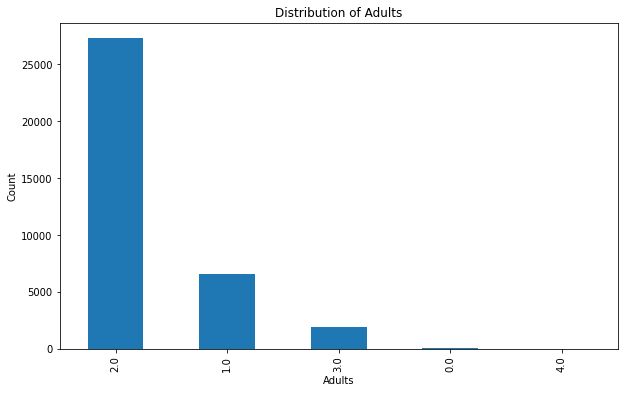

In [241]:
plt.figure(figsize=(10, 6))
df_train['adults'].value_counts().plot(kind='bar')

plt.xlabel('Adults')
plt.ylabel('Count')
plt.title('Distribution of Adults')

plt.show()

Судя по графику, чаще всего номера бронируют 2 взрослых. Так же видно небольшое значение возле 0. Пока не ясно с чем это связано.

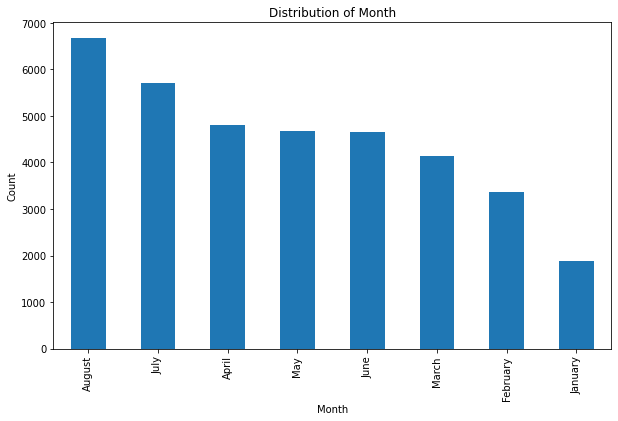

In [242]:

plt.figure(figsize=(10, 6))
df_train['arrival_date_month'].value_counts().plot(kind='bar')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Distribution of Month')

plt.show()

Чаще всего номера бронируют летом и весной. Меньше всего в январе. Логично предположить, что чем больше номеров бронируется - тем больше отменяется. Проверим эту гипотезу позднее.

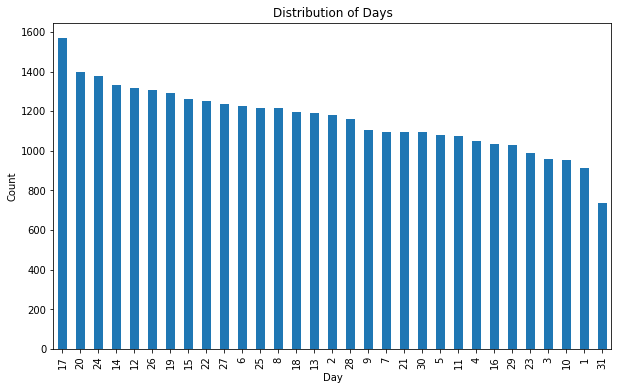

In [243]:

plt.figure(figsize=(10, 6))
df_train['arrival_date_day_of_month'].value_counts().plot(kind='bar')

plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Distribution of Days')

plt.show()

Как я и предпологал, особой закономерности здесь нет.

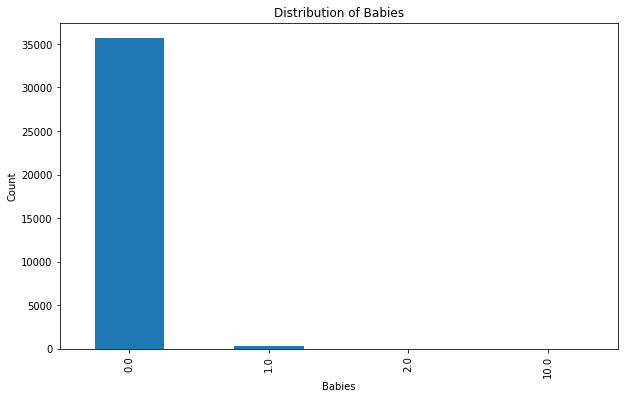

In [244]:

plt.figure(figsize=(10, 6))
df_train['babies'].value_counts().plot(kind='bar')

plt.xlabel('Babies')
plt.ylabel('Count')
plt.title('Distribution of Babies')

plt.show()

Можно сказать, что практически всегда номера бронируют без грудных детей.

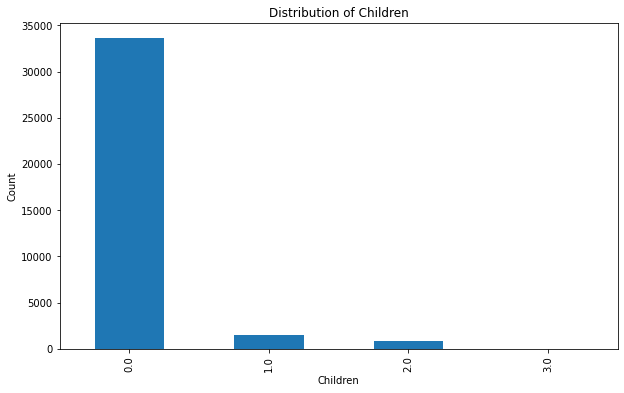

In [245]:
plt.figure(figsize=(10, 6))
df_train['children'].value_counts().plot(kind='bar')

plt.xlabel('Children')
plt.ylabel('Count')
plt.title('Distribution of Children')

plt.show()

Аналогично с детьми постарше. Можно сказать, что основной контингент, это взрослые без детей.

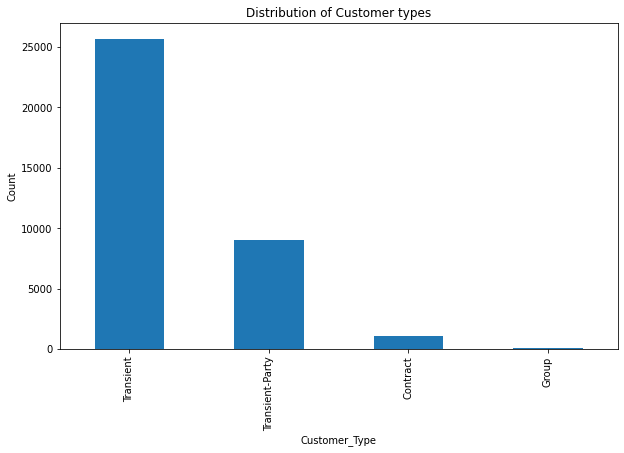

In [246]:

plt.figure(figsize=(10, 6))
df_train['customer_type'].value_counts().plot(kind='bar')

plt.xlabel('Customer_Type')
plt.ylabel('Count')
plt.title('Distribution of Customer types')

plt.show()

Большая часть бронирований не связана с юр лицами или групповыми заездами, т.е. частники. Кажется, что и отменяют бронь они чаще всего. Проверим эту гипотезу позже. 

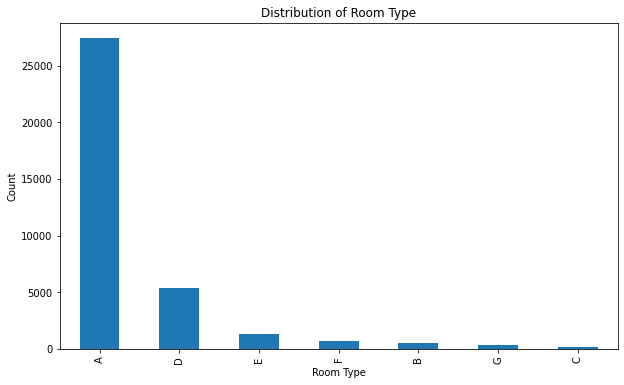

In [247]:

plt.figure(figsize=(10, 6))
df_train['reserved_room_type'].value_counts().plot(kind='bar')

plt.xlabel('Room Type')
plt.ylabel('Count')
plt.title('Distribution of Room Type')

plt.show()

Чаще всего бронируют самые дорогие комнаты и средние по стоимости (тип D)

In [248]:
# Т.к. нас интересуют случаи отмены брони, поэтому отсортируем данные
df_sorted = df_train[df_train['is_canceled'] == True]
display(df_sorted)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,new_price
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,...,0,A,0,0,Transient,0,1,3,400,1400.0
5,1,75.0,2015,July,27,1,0,3,2.0,0.0,...,0,D,0,0,Transient,0,0,3,150,770.0
6,1,23.0,2015,July,27,1,0,4,2.0,0.0,...,0,E,0,0,Transient,0,0,4,150,700.0
18,1,40.0,2015,July,27,2,1,3,3.0,0.0,...,0,D,0,0,Transient,0,1,4,150,770.0
22,1,45.0,2015,July,27,2,2,3,2.0,0.0,...,0,G,0,0,Transient,0,0,5,150,490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48027,1,4.0,2016,March,12,16,0,1,1.0,0.0,...,0,A,0,0,Transient,0,0,1,400,1200.0
48150,1,91.0,2016,March,12,18,0,1,2.0,0.0,...,0,D,0,0,Transient,0,0,1,150,660.0
49990,1,20.0,2016,May,22,26,0,1,1.0,0.0,...,1,D,2,0,Transient-Party,0,0,1,150,660.0
53799,1,26.0,2016,June,27,26,2,1,2.0,0.0,...,0,D,0,0,Transient,0,0,3,150,770.0


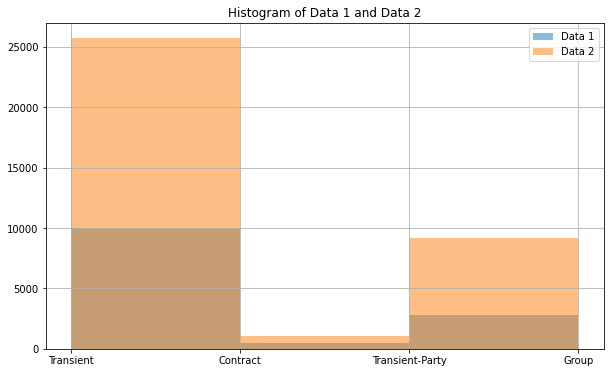

In [249]:
#посмотрим как выглядит соотношение отмены брони между разными типами гостей

data1 = df_sorted['customer_type']
data2 = df_train['customer_type']


fig, ax = plt.subplots(figsize=(10, 6))


ax.hist(data1, bins=3, alpha=0.5, label='Data 1')


ax.hist(data2, bins=3, alpha=0.5, label='Data 2')


ax.legend()
ax.set_title('Histogram of Data 1 and Data 2')
ax.grid(True)

plt.show()

Как ни странно, если смотреть в соотношении, то частники реже отменяют бронь, чем юр лица, несмотря на то, что глобально отмен со стороны частников больше.

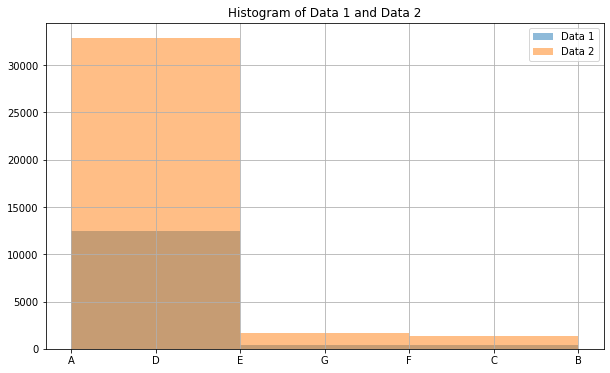

In [250]:
#посмотрим как выглядит соотношение отмены брони между разными типами комнат

data1 = df_sorted['reserved_room_type']
data2 = df_train['reserved_room_type']


fig, ax = plt.subplots(figsize=(10, 6))


ax.hist(data1, bins=3, alpha=0.5, label='Data 1')


ax.hist(data2, bins=3, alpha=0.5, label='Data 2')


ax.legend()
ax.set_title('Histogram of Data 1 and Data 2')
ax.grid(True)

plt.show()

Здесь соотношение нормальное. Все таки чаще отменяют типы комнат А и D, самые дорогие и средние по стоимости 

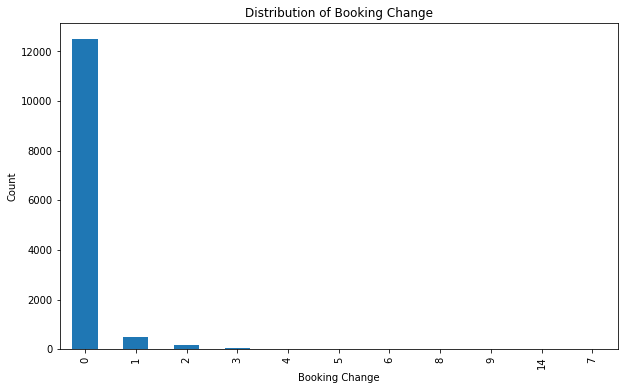

In [251]:
plt.figure(figsize=(10, 6))
df_sorted['booking_changes'].value_counts().plot(kind='bar')

plt.xlabel('Booking Change')
plt.ylabel('Count')
plt.title('Distribution of Booking Change')

plt.show()

Практически всегда не было изменений в бронировании несмотря на то, что в итоге их отменили. Значит эти данные нам не помогут

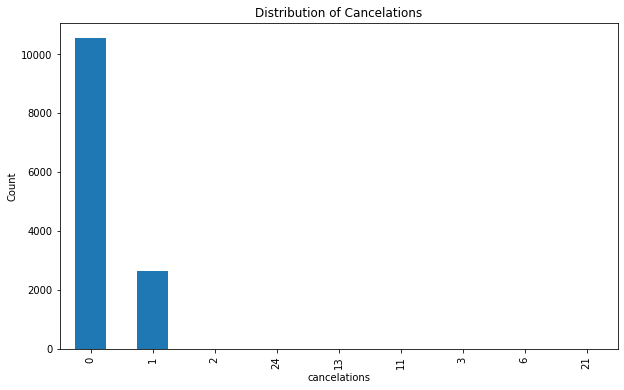

In [252]:
plt.figure(figsize=(10, 6))
df_sorted['previous_cancellations'].value_counts().plot(kind='bar')

plt.xlabel('cancelations')
plt.ylabel('Count')
plt.title('Distribution of Cancelations')

plt.show()

Около 25% отмен являются повторными. Попробуем детальнее посмотреть, кто же чаще всего отменяет бронирование повторно. 

In [253]:
df_sorted_by_secondary_cancelation = df_sorted[df_sorted['previous_cancellations'] ==1]
display(df_sorted_by_secondary_cancelation)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,new_price
6154,1,28.0,2016,June,25,13,1,3,1.0,0.0,...,3,A,0,0,Transient,0,0,4,400,1400.0
6190,1,202.0,2015,July,30,22,2,5,2.0,0.0,...,0,A,0,0,Contract,0,0,7,400,1400.0
6271,1,187.0,2015,August,32,4,0,5,2.0,0.0,...,0,E,0,0,Transient,0,2,5,150,700.0
6292,1,236.0,2015,July,29,12,2,4,2.0,0.0,...,0,A,0,0,Transient,0,0,6,400,1400.0
6293,1,210.0,2015,August,35,25,0,5,2.0,0.0,...,0,A,0,0,Transient,0,1,5,400,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45506,1,58.0,2016,January,5,27,0,2,1.0,0.0,...,0,A,0,0,Transient-Party,0,0,2,400,1000.0
46002,1,8.0,2016,February,9,25,0,2,1.0,0.0,...,1,A,0,0,Transient,0,0,2,400,1000.0
47585,1,2.0,2016,April,17,20,0,1,1.0,0.0,...,1,D,0,0,Transient,0,0,1,150,660.0
49990,1,20.0,2016,May,22,26,0,1,1.0,0.0,...,1,D,2,0,Transient-Party,0,0,1,150,660.0


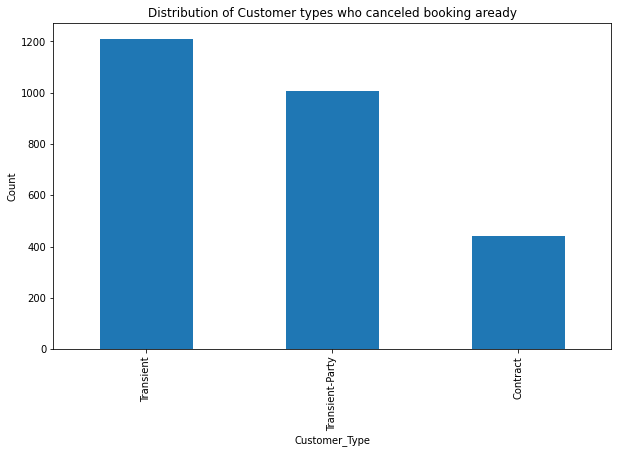

In [254]:
#посмотрим какие типы клиентов чаще отменяют бронировние не в 1 раз
plt.figure(figsize=(10, 6))
df_sorted_by_secondary_cancelation['customer_type'].value_counts().plot(kind='bar')

plt.xlabel('Customer_Type')
plt.ylabel('Count')
plt.title('Distribution of Customer types who canceled booking aready')

plt.show()

Получается, что несмотря на то, что в соотношении юр лица отменяют бронирования практически в 50% случаев, количество отмен среди чатников намного больше. Более того, примерно 1 из 5 отмен чатниками является повторным. 

Посмотрим еще на количество дней между датой бронирования и отмены

In [255]:
df_sorted = df_sorted.sort_values('lead_time', ascending=False)
display(df_sorted)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,new_price
30415,1,372.0,2016,July,29,14,0,2,2.0,0.0,...,0,A,0,0,Transient,0,0,2,400,1400.0
30426,1,372.0,2016,July,29,14,0,2,2.0,0.0,...,0,A,0,0,Transient,0,0,2,400,1400.0
30424,1,372.0,2016,July,29,14,0,2,2.0,0.0,...,0,A,0,0,Transient,0,0,2,400,1400.0
30423,1,372.0,2016,July,29,14,0,2,2.0,0.0,...,0,A,0,0,Transient,0,0,2,400,1400.0
30422,1,372.0,2016,July,29,14,0,2,2.0,0.0,...,0,A,0,0,Transient,0,0,2,400,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23482,1,0.0,2016,February,7,10,0,1,1.0,0.0,...,0,A,0,0,Transient,0,0,1,400,1000.0
3562,1,0.0,2016,April,18,29,0,2,1.0,0.0,...,0,A,0,0,Transient,0,0,2,400,1200.0
6013,1,0.0,2016,March,12,14,1,0,1.0,0.0,...,1,A,0,0,Transient,0,0,1,400,1200.0
25584,1,0.0,2016,April,16,11,1,0,2.0,0.0,...,0,A,0,0,Transient,0,0,1,400,1200.0


In [256]:
lead_time_pivot = df_sorted[df_sorted['customer_type'] == 'Contract']
display(lead_time_pivot)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,new_price
37666,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37681,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37671,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37672,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37682,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18292,1,4.0,2015,August,35,23,2,3,1.0,0.0,...,0,A,0,0,Contract,0,0,5,400,1400.0
18246,1,3.0,2015,August,34,22,1,1,2.0,0.0,...,0,A,0,0,Contract,0,2,2,400,1400.0
17877,1,3.0,2015,August,33,14,1,2,2.0,0.0,...,0,A,0,0,Contract,0,2,3,400,1400.0
18170,1,1.0,2015,August,34,20,0,2,2.0,0.0,...,0,A,0,0,Contract,0,3,2,400,1400.0


In [257]:
lead_time_pivot['lead_time'].value_counts()

279.0    21
265.0    21
262.0    20
276.0    20
314.0    20
         ..
273.0     1
169.0     1
136.0     1
157.0     1
54.0      1
Name: lead_time, Length: 92, dtype: int64

In [258]:
lead_more_than_half_year = lead_time_pivot[lead_time_pivot['lead_time'] > 250]
display(lead_more_than_half_year)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,new_price
37666,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37681,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37671,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37672,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37682,1,318.0,2015,August,36,31,1,1,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37086,1,258.0,2015,July,27,2,0,2,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37111,1,258.0,2015,July,27,2,0,2,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37110,1,258.0,2015,July,27,2,0,2,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0
37107,1,258.0,2015,July,27,2,0,2,2.0,0.0,...,0,A,0,0,Contract,0,0,2,400,1400.0


Судя по всему, юр лица бронируют номера практически за год вперед и потом отменяют их. Кажется, это важный нюанс, который стоит учесть. 

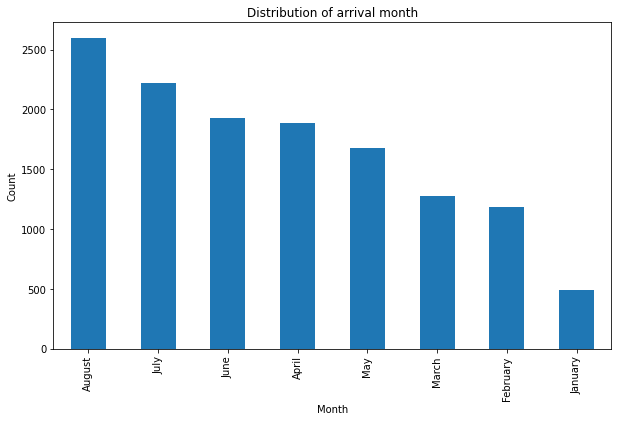

In [259]:
# посмотрим на количество отмен бронирований по месяцам
plt.figure(figsize=(10, 6))
df_sorted['arrival_date_month'].value_counts().plot(kind='bar')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Distribution of arrival month')

plt.show()

Топ по отменам, это лето и вторая половина весны. Скорее всего, это связано с сезоном отпусков. Лидер здесь Август( максимально количество отмен), затем идет Июль, Июнь и Апрель и Май. Меньше всего отмен в Январе, но связано это с количеством бронирований в принципе

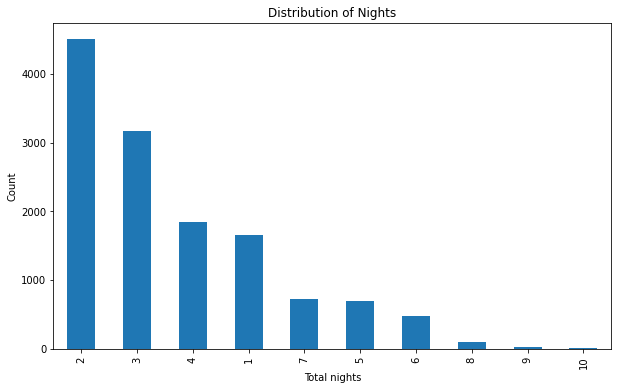

In [260]:
#посмотрим на какое количество ночей обычно бронируют номера, которые в итоге отменяются
plt.figure(figsize=(10, 6))
df_sorted['total_nights'].value_counts().plot(kind='bar')

plt.xlabel('Total nights')
plt.ylabel('Count')
plt.title('Distribution of Nights')

plt.show()

Судя по графику чаще всего отменяют номера с бронью 2-3 ночи, реже на 1 и 4 ночи, совсем редко отменяют номера, кторые бронируются от 8 ночей и выше

### Промежуточный вывод 

- Загружены 2 датасета с информацией о бронировании. 
- Проведена предобработка данных, а именно поиск пропусков, аномальных значений, разности данных.
- В некоторых столбцах были найдены и удалены лишние пробелы.
- Добавлены 2 новых столбца с ценой и стоимостью обслуживания.
- Тип данных в некоторых столбцах был изменен на более подходящий.
- Проведен анализ данных и выявлены следующие закономерности: 
- Чаще всего номера бронируют 2 взрослых, летом и весной. Меньше всего в январе.
- Топ отмен приходится на Август, Июнь, Июль и Апрель. Связано скорее всего с сезоном отпусков.
- Основной контингент, это взрослые без детей.
- Большая часть бронирований не связана с юр лицами или групповыми заездами, т.е. частники. Отменяют бронь они чаще всего.
- Чаще всего бронируют самые дорогие комнаты или средние по стоимости (тип D). Соответственно и отменяют их чаще остальных.
- Если смотреть в соотношении, то чатники реже отменяют бронь, чем юр лица, несмотря на то, что глобально отмен со стороны частников больше.
- Около 25% отмен являются повторными.
- Несмотря на то, что в соотношении юр лица отменяют бронирования практически в 50% случаев, количество отмен среди чатников намного больше. Более того, примерно 1 из 5 отмен чатниками является повторным.
- Юр лица бронируют номера практически за год вперед и потом отменяют их.
- Чаще всего отменяют номера с бронью 2-3 ночи, реже на 1 и 4 ночи, совсем редко отменяют номера, кторые бронируются от 8 ночей и выше.

## Формулировка ML-задачи на основе бизнес-задачи

In [261]:
def calculate_profit(row):
    season_coefficient = 1
    if row['arrival_date_month'] in ['March', 'April', 'May', 'September', 'October', 'November']:
        season_coefficient = 1.2
    elif row['arrival_date_month'] in ['June', 'July', 'August']:
        season_coefficient = 1.4

    nights = row['total_nights']
    accommodation_cost = row['new_price'] * nights

    cleaning_cost = row['cleaning_cost'] * int(nights / 2) if nights > 2 else row['cleaning_cost']

    total_cost = accommodation_cost + cleaning_cost

    cancellation_loss = 0
    if row['is_canceled'] == 1:
        cancellation_loss = row['new_price'] + row['cleaning_cost']

    profit = total_cost - cancellation_loss
    return profit

df_train['profit'] = df_train.apply(calculate_profit, axis=1)
df_test['profit'] = df_test.apply(calculate_profit, axis=1)

total_profit = df_train['profit'].sum()
print('Прибыль отеля:', total_profit)


Прибыль отеля: 119004010.0


Перед началом разработки и тестирования моделей, сформируем ML-задачу. 

Целевой признак в данном случае, это отказ от брони или столбец 'is_canceled'.

Цель: Предсказать, будет ли клиент отказываться от бронирования номера в отеле или нет.

Бизнес метрика для максимизации прибыли: F1 - мера точности модели

## Разработка модели ML

Теперь можно переходить к энкодингу

In [262]:
features = df_train.drop('is_canceled', axis=1)
target = df_train['is_canceled']

In [263]:
#разделение на признаки для тестовой и валидационной выборок
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

In [264]:
encoder_train = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse=False)
encoder_train.fit(features_train)
features_train_ohe = encoder_train.transform(features_train)
features_valid_ohe = encoder_train.transform(features_valid)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

  warnings.warn(

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 9, 12, 13, 16, 23] during transform. These unknown categories will be encoded as all zeros

  warnings.warn(


Теперь можно переходить к тестированию и обучению моделей. 

Кажется, что в данном случае нам подойдут модели логистической регрессии и случайного леса.

In [272]:
# Возьмем для обучения модель случайного леса. начнем с подбора гиперпараметров
best_score = float('-inf')
best_depth = 0

for depth in range(1, 16):
    model = RandomForestClassifier(n_estimators=10, max_depth=depth, random_state=12345)
    model.fit(features_train_ohe, target_train)
    predict = model.predict(features_valid_ohe)
    score = f1_score(target_valid, predict)
    
    if score > best_score:
        best_score = score
        best_depth = depth

print("Best depth:", best_depth)
print("Best score:", best_score)

Best depth: 15

Best score: 0.747536012130402


In [273]:
best_score = float('-inf')
best_est = 0

for est in range(1, 16):
    model = RandomForestClassifier(n_estimators=est, max_depth=15, random_state=12345)
    model.fit(features_train_ohe, target_train)
    predict = model.predict(features_valid_ohe)
    score = f1_score(target_valid, predict)
    
    if score > best_score:
        best_score = score
        best_est = est

print("Best estimators:", best_est)
print("Best score:", best_score)

Best estimators: 6

Best score: 0.7638059701492537


In [274]:
rfc_model = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=6)
rfc_scores = cross_val_score(rfc_model, features_train_ohe, target_train, cv=5, scoring='f1')
final_rfc_score = sum(rfc_scores)/ len(rfc_scores)
print('Средняя оценка качества модели:', final_rfc_score)

Средняя оценка качества модели: 0.767511002138592


Средняя оценка модели случайного леса 0.76. Выберем эту модель как лучшую и протестируем на тестовой выборке.

In [275]:
best_model = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=6)
best_model.fit(features_train_ohe, target_train)

RandomForestClassifier(max_depth=15, n_estimators=6, random_state=12345)

In [276]:
features_test = df_test.drop('is_canceled', axis=1)
target_test = df_test['is_canceled']
features_test_ohe = encoder_train.transform(features_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 12, 13, 15, 16, 18, 23] during transform. These unknown categories will be encoded as all zeros

  warnings.warn(


In [277]:
predictions = best_model.predict(features_test_ohe)
accuracy = best_model.score(features_test_ohe, target_test)

# Вывод метрик
print("Точность модели на тестовой выборке:", accuracy)
print('F1:', f1_score(target_test, predictions))
print('Полнота', recall_score(target_test, predictions))

Точность модели на тестовой выборке: 0.8142046155744785

F1: 0.6892031379025598

Полнота 0.5302994202207927


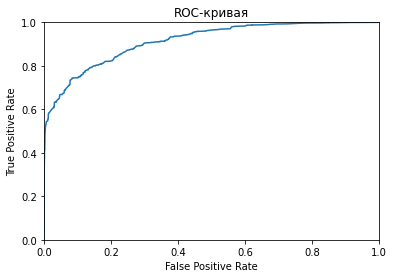

In [278]:
probabilities = best_model.predict_proba(features_test_ohe)
probabilities_one = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)

plt.figure()
figsize=(6, 6)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr, tpr)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [279]:
auc_roc = roc_auc_score(target_test, probabilities_one)
print(auc_roc)

0.9138666552099874


Если сравнивать все метрики, то в итоге получается результат.

Точность = 0.81

Полнота = 0.53

F1 = 0.68

Roc-Auc = 0.91

In [280]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
print('F1 константной модели:', f1_score(dummy_model.predict(features_test), target_test))

F1 константной модели: 0.5595626958202786


Сравнение метрик F1 константной модели и модели случайного леса подтверждает ее вменяемость

In [281]:
# Добавим столбец prediction
df_test['prediction'] = predictions

In [282]:
# Добавим столбец deposit
def deposit(row):
    prediction = row['prediction']
    price = row['new_price']
    
    
    if prediction == True:
        deposit = price * 0.8
    if prediction == False:
        deposit = 0
    return deposit

In [283]:
# Применим функцию и добавим столбец deposit
df_test['deposit'] = df_test.apply(deposit, axis=1)

In [284]:
df_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cleaning_cost,new_price,profit,prediction,deposit
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,...,0,Transient,0,0,1,400,1000.0,0.0,0,0.0
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,...,0,Transient,0,1,4,400,1000.0,3400.0,0,0.0
2,1,62.0,2017,January,1,1,2,2,2.0,0.0,...,0,Transient,0,1,4,400,1000.0,3400.0,0,0.0
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,...,0,Transient,0,1,4,400,1000.0,3400.0,0,0.0
4,1,172.0,2017,January,1,1,2,5,2.0,0.0,...,0,Transient,0,0,7,400,1000.0,6800.0,0,0.0


In [285]:
# Рассчитаем прибыль, которую принесет модель
df_test['deposit'].sum()

6566576.0

Прибыль, которую принесет модель явно выше бюджета на ее разработку.

## Портрет «ненадёжного» клиента

На основании тех закономертностей, которые были выявлены на этапе предобработки данных, "ненадежный клиент" выглядит следующим образом:

Основные признаки:
- Бронирует номер на 2 взрослых;
- Бронирует номер на Август/Июнь/Июль/Апрель;
- Бронирует номер как частное лицо;
- Бронирует комнату типа A или D;
- Бронирует номер на 2 - 3 ночи
- Бронирует номер более чем за полгода вперед.

Дополнительный признак:
- Вероятно уже было бронирование, которое он отменил; 

## Общий вывод

Предобработка данных
- Загружены 2 датасета с информацией о бронировании. 
- Проведена предобработка данных, а именно поиск пропусков, аномальных значений, разности данных.
- В некоторых столбцах были найдены и удалены лишние пробелы.
- Добавлены 2 новых столбца с ценой и стоимостью обслуживания.
- Тип данных в некоторых столбцах был изменен на более подходящий.

Проведен анализ данных и выявлены следующие закономерности: 
- Чаще всего номера бронируют 2 взрослых, летом и весной. Меньше всего в январе.
- Топ отмен приходится на Август, Июнь, Июль и Апрель. Связано скорее всего с сезоном отпусков.
- Основной контингент, это взрослые без детей.
- Большая часть бронирований не связана с юр лицами или групповыми заездами, т.е. частники. Отменяют бронь они чаще всего.
- Чаще всего бронируют самые дорогие комнаты или средние по стоимости (тип D). Соответственно и отменяют их чаще остальных.
- Если смотреть в соотношении, то чатники реже отменяют бронь, чем юр лица, несмотря на то, что глобально отмен со стороны частников больше.
- Около 25% отмен являются повторными.
- Несмотря на то, что в соотношении юр лица отменяют бронирования практически в 50% случаев, количество отмен среди чатников намного больше. Более того, примерно 1 из 5 отмен чатниками является повторным.
- Юр лица бронируют номера практически за год вперед и потом отменяют их.
- Чаще всего отменяют номера с бронью 2-3 ночи, реже на 1 и 4 ночи, совсем редко отменяют номера, кторые бронируются от 8 ночей и выше.

Посчитана прибыль без учета депозитов: 119004010.

Обучение моделей
- Проведен энкодинг данных перед обучением моделей.
- Изначально было построено 2 модели ML - логистическая регрессия и модель случайного леса.
- По результатам обучения выбрана модель случайного леса для дальнейшего тестирования на тестовой выборке.

Тестирование выбранной модели
- При тестировании получены следующие результаты: F1: 0.68, Полнота 0.53, точность модели на тестовой выборке: 0.81, Roc-Auc: 0.91
- Для проверки вменяемости модели обучена константная модель. 
- Ее метрика F1: 0.55, что подтверждает вменяемость модели.
- Добавлен столбец deposit и подсчитана прибыль, которую принесет модель: 6566576.0
- Прибыль явно выше бюджета на разработку. 
 
Также выявлены основные характеристики ненадежного клиента.
Основные признаки:
- Бронирует номер на 2 взрослых;
- Бронирует номер на Август/Июнь/Июль/Апрель;
- Бронирует номер как частное лицо;
- Бронирует комнату типа A или D;
- Бронирует номер на 2 - 3 ночи
- Бронирует номер более чем за полгода вперед.

Дополнительный признак:
- Вероятно уже было бронирование, которое он отменил;  